## Competitive/Collaborative dFBA

In this section, we present an application of competitive **dynamic parallel Flux Balance Analysis** (dpFBA). Competitive dpFBA extends traditional dFBA by allowing multiple interacting agents or organisms to compete or even collaborate for limited resources within a shared environment. This approach allows for a more comprehensive understanding of metabolic interactions and resource allocation in complex microbial communities.

In the following example we implement a collaborative dFBA model in which two different mutant strains of *E. coli*, one incapable of respiring due to a mutation in the terminal oxidase, and the other incapable of fermenting due to a mutation in the glucose transporter, help each other grow.


In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
%matplotlib inline

Create or load a cobrapy model. Here, we use the 'textbook' e-coli core model.

In [57]:
import cobra
from cobra.io import load_model
model1 = load_model('textbook')
model2 = load_model('textbook')

In [58]:
model1.reactions

[<Reaction ACALD at 0x147cf9000>,
 <Reaction ACALDt at 0x147d10340>,
 <Reaction ACKr at 0x147d11180>,
 <Reaction ACONTa at 0x147d11000>,
 <Reaction ACONTb at 0x147d11a20>,
 <Reaction ACt2r at 0x147d11c30>,
 <Reaction ADK1 at 0x147d11fc0>,
 <Reaction AKGDH at 0x147d11d80>,
 <Reaction AKGt2r at 0x147d126e0>,
 <Reaction ALCD2x at 0x147d12dd0>,
 <Reaction ATPM at 0x147d12cb0>,
 <Reaction ATPS4r at 0x147d136d0>,
 <Reaction Biomass_Ecoli_core at 0x147d121d0>,
 <Reaction CO2t at 0x147d13610>,
 <Reaction CS at 0x147d118a0>,
 <Reaction CYTBD at 0x147d12620>,
 <Reaction D_LACt2 at 0x147d24b80>,
 <Reaction ENO at 0x147d26050>,
 <Reaction ETOHt2r at 0x147d26470>,
 <Reaction EX_ac_e at 0x147d12c50>,
 <Reaction EX_acald_e at 0x147d13fa0>,
 <Reaction EX_akg_e at 0x147d13f40>,
 <Reaction EX_co2_e at 0x147d132b0>,
 <Reaction EX_etoh_e at 0x147d25ea0>,
 <Reaction EX_for_e at 0x147d265f0>,
 <Reaction EX_fru_e at 0x147d26680>,
 <Reaction EX_fum_e at 0x147d26740>,
 <Reaction EX_glc__D_e at 0x147d26800>,
 <

In [59]:
print(model1.reactions.EX_glc__D_e.bounds)
print(model1.reactions.EX_for_e.bounds)
print(model1.reactions.EX_ac_e.bounds)
print(model1.reactions.EX_etoh_e.bounds)
print(model1.reactions.EX_o2_e.bounds)

(-10.0, 1000.0)
(0.0, 1000.0)
(0.0, 1000.0)
(0.0, 1000.0)
(-1000.0, 1000.0)


In [60]:
sol = model1.optimize()
sol

,fluxes,reduced_costs
ACALD,0.000000,2.602085e-18
ACALDt,0.000000,0.000000e+00
ACKr,0.000000,-0.000000e+00
ACONTa,6.007250,0.000000e+00
ACONTb,6.007250,0.000000e+00
...,...,...
TALA,1.496984,0.000000e+00
THD2,0.000000,-2.546243e-03
TKT1,1.496984,0.000000e+00
TKT2,1.181498,1.387779e-17


In [61]:
sol.fluxes.get('EX_o2_e')

-21.79949265599875

We knock out the terminal oxidase in the first model

In [62]:
model1.reactions.CYTBD.knock_out()
print(f'Mutant E. coli with terminal oxidase knocked out: {model1.optimize()}')

Mutant E. coli with terminal oxidase knocked out: <Solution 0.212 at 0x147c27310>


We knock out the glucose transporter in the second model, but allow uptake of acetate, and ethanol.

In [63]:
model2.reactions.EX_glc__D_e.bounds = (-10.0,1000.)
model2.reactions.EX_for_e.bounds = (0., 1000.)
model2.reactions.EX_ac_e.bounds = (-10., 1000.)
model2.reactions.EX_etoh_e.bounds = (-10., 10.)
model2.reactions.EX_o2_e.bounds = (-1000., 1000.)

print(model2.reactions.EX_glc__D_e.bounds)
print(model2.reactions.EX_for_e.bounds)
print(model2.reactions.EX_ac_e.bounds)
print(model2.reactions.EX_etoh_e.bounds)
print(model2.reactions.EX_o2_e.bounds)

(-10.0, 1000.0)
(0.0, 1000.0)
(-10.0, 1000.0)
(-10.0, 10.0)
(-1000.0, 1000.0)


In [64]:
model2.reactions.GLCpts.knock_out()
print(f'Mutant E. coli with glucose uptake knocked out: {model2.optimize()}')

Mutant E. coli with glucose uptake knocked out: <Solution 0.550 at 0x147e939d0>


In [65]:
sol2 = model2.optimize()
sol2

,fluxes,reduced_costs
ACALD,10.000000,-2.602085e-18
ACALDt,0.000000,0.000000e+00
ACKr,10.000000,0.000000e+00
ACONTa,12.239977,0.000000e+00
ACONTb,12.239977,0.000000e+00
...,...,...
TALA,-0.098322,-0.000000e+00
THD2,1.919718,0.000000e+00
TKT1,-0.098322,-0.000000e+00
TKT2,-0.296725,1.387779e-17


In [66]:
sol2.fluxes.get('EX_o2_e')

-25.976442530902162

### Dynamic setup for model 1 (E. coli without terminal oxidase, secreting acetate and ethanol)

In [67]:
def add_dynamic_bounds_1(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose, acetate, etoh, o2 = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import

    acetate_max_import = -10 * acetate / (1 + acetate)
    acetate_max_export = 10 * acetate / (1 + acetate)
    model.reactions.EX_ac_e.lower_bound = acetate_max_import
    model.reactions.EX_ac_e.upper_bound = acetate_max_export

    # Ethanol diffuses freely
    etoh_max_import = -10 * etoh
    etoh_max_export = 10 * etoh
    model.reactions.EX_etoh_e.lower_bound = etoh_max_import        
    model.reactions.EX_etoh_e.upper_bound = etoh_max_export
    
    # block O2 consumption
    model.reactions.EX_o2_e.lower_bound = 0.0
    model.reactions.EX_o2_e.upper_bound = 0.0

def dynamic_system_1(t, y):
    """Calculate the time derivative of external species."""

    global feasibility_1

    biomass, glucose, acetate, etoh, o2 = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    fluxes = np.zeros(5)
    with model:
        add_dynamic_bounds_1(model, y)
        
        model.slim_optimize()

        if not model.solver.status == 'infeasible':
            all_fluxes = model.optimize()
            # if using parsimonious FBA
            # all_fluxes = cobra.flux_analysis.pfba(model)
            feasibility_1 = -1.0

            for i,obj in enumerate(['Biomass_Ecoli_core', 'EX_glc__D_e', 'EX_ac_e', 'EX_etoh_e', 'EX_o2_e']):                
                fluxes[i] = all_fluxes.fluxes.get(obj)
            
            # Since the calculated fluxes are specific rates, we multiply them by the
            # biomass concentration to get the bulk exchange rates.
            fluxes *= biomass

        else:
            feasibility_1 = 0.0      

    return fluxes


def infeasible_event_1(t, y):
    """
    Determine solution feasibility.
    
    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function just passes the infeasible variable calculated by dynamic_system_1.

    """

    return feasibility_1

infeasible_event_1.direction = 1
infeasible_event_1.terminal = True


### Dynamic setup for model 2 (E. coli without glucose transporter, importing acetate and ethanol)

In [68]:
def add_dynamic_bounds_2(model, y):
    """Use external concentrations to bound the uptake flux of acetate and ethanol."""

    biomass, glucose, acetate, etoh, o2 = y  # expand the boundary species
    
    # Block glucose uptake
    model.reactions.EX_glc__D_e.upper_bound = 0.0
    model.reactions.EX_glc__D_e.lower_bound = 0.0

    acetate_max_import = -10. * acetate / (1 + acetate)
    acetate_max_export = 10. * acetate / (1 + acetate)
    model.reactions.EX_ac_e.lower_bound = acetate_max_import    
    model.reactions.EX_ac_e.upper_bound = acetate_max_export

    etoh_max_import = -10. * etoh
    etoh_max_export = 10. * etoh 
    model.reactions.EX_etoh_e.lower_bound = etoh_max_import    
    model.reactions.EX_etoh_e.upper_bound = etoh_max_export

    # Terminal oxidase with high affinity for O2
    o2_max_import = -20 * o2 / (0.01 + o2)
    model.reactions.EX_o2_e.lower_bound = o2_max_import
    model.reactions.EX_o2_e.upper_bound = 20 * o2    
    

def dynamic_system_2(t, y):
    """Calculate the time derivative of external species."""

    global feasibility_2

    biomass, glucose, acetate, etoh, o2 = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    fluxes = np.zeros(5)
    with model:
        add_dynamic_bounds_2(model, y)
        
        model.slim_optimize()

        if not model.solver.status == 'infeasible':
            all_fluxes = model.optimize()
            feasibility_2 = -1.0

            for i,obj in enumerate(['Biomass_Ecoli_core', 'EX_glc__D_e', 'EX_ac_e', 'EX_etoh_e', 'EX_o2_e']):                
                fluxes[i] = all_fluxes.fluxes.get(obj)
            
            # Since the calculated fluxes are specific rates, we multiply them by the
            # biomass concentration to get the bulk exchange rates.
            fluxes *= biomass

        else:
            feasibility_2 = 0.0      

    return fluxes


def infeasible_event_2(t, y):
    """
    Determine solution feasibility.
    
    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function just passes the infeasible variable calculated by dynamic_system_2.

"""
    return feasibility_2

infeasible_event_2.direction = 1
infeasible_event_2.terminal = True

#### Initialize tensorboard

In [69]:
# ! pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
tbwriter = SummaryWriter('logs/init_writer')

Launch a Tensorboard session. The session will populate after model training starts.

To display the TensorBoard application, you need to start the TensorBoard server and then open the TensorBoard interface in your web browser. Here are the steps:

##### 1. Start the TensorBoard Server

Open a terminal, **activate the conda environment** in which your notebook is running, and navigate to the directory where your logs folder is stored. If your logs are stored in the `logs` directory, you can start TensorBoard with the following command:

```sh
tensorboard --logdir=logs
```

After starting the TensorBoard server, you will see an output similar to this:

```
TensorBoard 2.x.x at http://localhost:6006/ (Press CTRL+C to quit)
```

Open your web browser and go to the URL provided, typically `http://localhost:6006/`.

This will display the TensorBoard interface where you can visualize your logs and other metrics. This is by far the most reliable method to start a Tensorboard session.

You can also display http://localhost:6006/ directly inside VS code by launching the built-in browser (Cmd+Shift+P and then select "Simple Browser").

##### 2. Open TensorBoard in a notebook cell
Alternatively, you can start the session in a cell with the syntax shown below, and then go to http://localhost:6006/, or go back to the cell output during the run execution. Another alternative is to activate the cell in a different jupyter notebook, and then periodically check the status of training in that notebook.

```python
%load_ext tensorboard
%tensorboard --logdir logs
```

However, using this method, it may be difficult to terminate the session, and/or restart a new one without restarting VS code.


### Growth with constant supply of O2 (open system in equilibrium with air)

In [ ]:
import copy

# Here we will use an initial concentration of glucose higher than the transport upper bound

# Prepare the initial conditions for the two models.
niter = 2000

mass_global = np.zeros((2,niter+1))
glucose_global = np.zeros(niter+1)
acetate_global = np.zeros(niter+1)
etoh_global = np.zeros(niter+1)
o2_global = np.zeros(niter+1)

sol1_global = np.zeros((5,niter+1))
sol2_global = np.zeros((5,niter+1))
sol_status_global = np.zeros((2,niter+1))

# Initial conditions
y0_1_mass = 0.1
y0_2_mass = 0.01
y0_glucose = 20
y0_acetate = 0.4 # minimal external concentration to support growth
y0_etoh = 0.4 # minimal external concentration to support growth
y0_o2 = 0.273 # initial oxygen concentration
# y0_o2 = 1.0 # initial oxygen concentration

y0_1 = [y0_1_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2
y0_2 = [y0_2_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2  

# Initialize global solutions with initial conditions
sol1_global[:, 0] = y0_1  # Initial conditions for biomass, glucose and acetate in model1
sol2_global[:, 0] = y0_2  # Initial conditions for biomass, glucose and acetate in model2
sol_status_global[:, 0] = [0, 0]  # Initial status: 0 means successful integration, 1 means event triggered

# Initialize global concentrations with initial conditions for each concentration calculated explicitly
mass_global[:, 0] = [y0_1_mass, y0_2_mass]
glucose_global[0] = y0_glucose
acetate_global[0] = y0_acetate
etoh_global[0] = y0_etoh
o2_global[0] = y0_o2

# Initialize tensortboard logs for time 0
with tbwriter as writer:
    writer.add_scalar('mass_model_1', y0_1_mass, 0)
    writer.add_scalar('mass_model_2', y0_2_mass, 0)
    writer.add_scalar('glucose', y0_glucose, 0)
    writer.add_scalar('acetate', y0_acetate, 0)
    writer.add_scalar('etoh', y0_etoh, 0)
    writer.add_scalar('o2', y0_o2, 0)

t_global = [0]
delta_t = 0.01

for iter in tqdm(range(niter)):

    # Every 10 iteration bring back glucose and O2 concentration to original value
    # if iter % 10 == 0:
    #     y0_glucose = 20
    #     y0_1[1] = y0_glucose
    #     y0_2[1] = y0_glucose
    
    y0_o2 = 0.273
    y0_1[4] = y0_o2
    y0_2[4] = y0_o2

    ts = np.linspace(0, delta_t, 2)  # Desired integration resolution and interval

    if iter>0 and sol_status_global[0, iter-1] == 1:
        # print(f"Skipping sol1 due to infeasibility in model 1")
        pass
    else:

        with model1 as model:

            sol1 = solve_ivp(
                fun=dynamic_system_1,
                events=[infeasible_event_1],
                t_span=(ts.min(), ts.max()),
                y0=y0_1,
                t_eval=ts,
                rtol=1e-6,
                atol=1e-8,
                method='RK45'
            )
            # print(f'sol1 status: {sol1["status"]}')

    if iter>0 and sol_status_global[1, iter-1] == 1:
        # print(f"Skipping sol2 due to infeasibility in model 2")
        pass
    else:

        with model2 as model:

            sol2 = solve_ivp(
                fun=dynamic_system_2,
                events=[infeasible_event_2],
                t_span=(ts.min(), ts.max()),
                y0=y0_2,
                t_eval=ts,
                rtol=1e-6,
                atol=1e-8,
                method='RK45'
            )
            # print(f'sol2 status: {sol2["status"]}')

    # Store the time points
    t_global.append(t_global[-1] + delta_t)            

    # Store the individual solutions in the global solutions
    sol1_global[:, iter+1] = sol1['y'][:, -1]
    sol2_global[:, iter+1] = sol2['y'][:, -1]
    sol_status_global[:, iter+1] = sol1['status'], sol2['status']

    # Update the masses
    y0_1_mass = sol1['y'][0, -1]
    y0_2_mass = sol2['y'][0, -1]

    # Update the glucose and acetate concentrations subtracting the initial value
    # from the sum of both strains updates for production or consumption
    d1_glucose = sol1['y'][1,0]-sol1['y'][1,-1]
    d2_glucose = sol2['y'][1,0]-sol2['y'][1,-1] 
    y0_glucose = y0_glucose - d1_glucose - d2_glucose

    d1_acetate = sol1['y'][2,0]-sol1['y'][2,-1]
    d2_acetate = sol2['y'][2,0]-sol2['y'][2,-1]
    y0_acetate = y0_acetate - d1_acetate - d2_acetate

    d1_etoh = sol1['y'][3,0]-sol1['y'][3,-1]
    d2_etoh = sol2['y'][3,0]-sol2['y'][3,-1]
    y0_etoh = y0_etoh - d1_etoh - d2_etoh

    d1_o2 = sol1['y'][4,0]-sol1['y'][4,-1]
    d2_o2 = sol2['y'][4,0]-sol2['y'][4,-1]
    y0_o2 = y0_o2 - d1_o2 - d2_o2

    # Update the initial conditions for both strains
    y0_1 = [y0_1_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2]
    y0_2 = [y0_2_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2]

    # Store the results in the global solutions
    mass_global[:, iter+1] = [y0_1_mass, y0_2_mass]
    glucose_global[iter+1] = y0_glucose
    acetate_global[iter+1] = y0_acetate
    etoh_global[iter+1] = y0_etoh
    o2_global[iter+1] = y0_o2

    # Save logs for tensorboard
    # with writer as tbwriter:
    tbwriter.add_scalar('mass_model_1', y0_1_mass, iter+1)
    tbwriter.add_scalar('mass_model_2', y0_2_mass, iter+1)
    tbwriter.add_scalar('glucose', y0_glucose, iter+1)
    tbwriter.add_scalar('acetate', y0_acetate, iter+1)
    tbwriter.add_scalar('etoh', y0_etoh, iter+1)
    tbwriter.add_scalar('o2', y0_o2, iter+1)

    # tbwriter.add_scalar('status_model_1', sol1['status'], iter+1)
    # tbwriter.add_scalar('status_model_2', sol2['status'], iter+1)

    if sol1['status'] == 1 and sol2['status'] == 1:
        print(f"Both solutions are infeasible")
        break

    # Break tolerance on masses in the last 5 time points
    # n_t = len(t_global)
    # if n_t > 5 and np.max(np.abs(np.diff(mass_global[:, n_t-5:n_t], axis=1))) < 1e-3:
    #     print(f"Mass balance converged")
    #     break


  0%|          | 0/2000 [00:00<?, ?it/s]

 57%|█████▋    | 1134/2000 [01:57<01:29,  9.65it/s]

Both solutions are infeasible


#### Plot timelines of biomass, glucose, acetate, etoh and o2

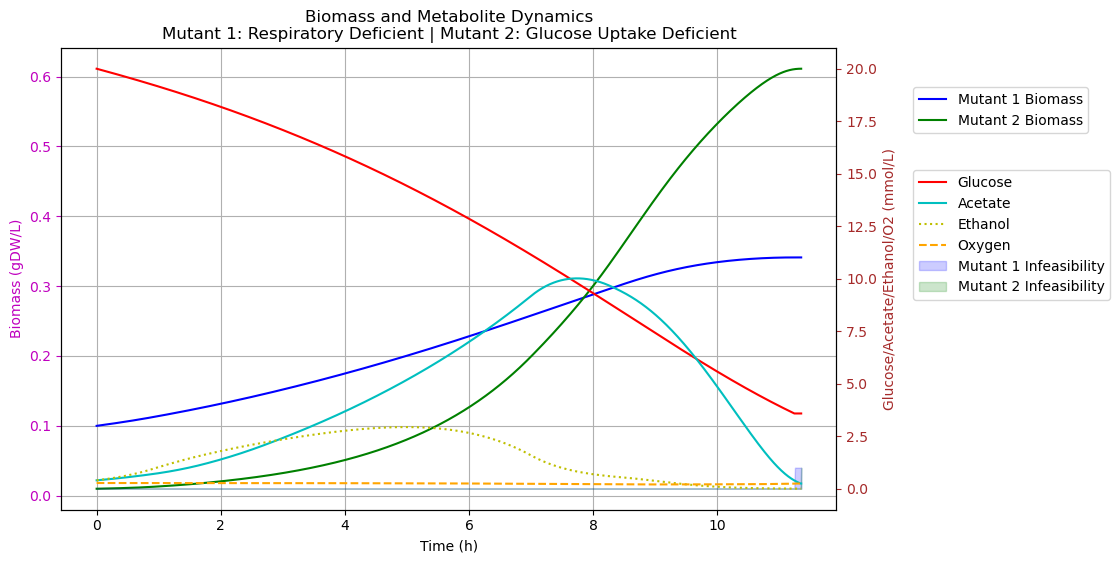

In [74]:
# t = np.linspace(0, niter * 0.01, niter + 1)
n_t = len(t_global)
t = t_global

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(t, mass_global[0][:n_t], label='Mutant 1 Biomass', color='b')
ax.plot(t, mass_global[1][:n_t], label='Mutant 2 Biomass', color='g')
ax.tick_params(axis='y', colors='m')
ax2 = plt.twinx(ax)
ax2.plot(t, glucose_global[:n_t], color='r', label='Glucose')
ax2.plot(t, acetate_global[:n_t], color='c', label='Acetate', linestyle='-')
ax2.plot(t, etoh_global[:n_t], color='y', label='Ethanol', linestyle=':')
ax2.plot(t, o2_global[:n_t], color='orange', label='Oxygen', linestyle='--')
ax2.tick_params(axis='y', colors='brown')

# plot on secondary y-axis the status of both models as colored bars going from 0 to the value of the status

ax2.fill_between(t, 0, sol_status_global[0][:n_t], color='b', alpha=0.2, label='Mutant 1 Infeasibility')
ax2.fill_between(t, 0, sol_status_global[1][:n_t], color='g', alpha=0.2, label='Mutant 2 Infeasibility')

ax.set_ylabel('Biomass (gDW/L)', color='m')
ax.set_xlabel('Time (h)', color='k')
ax2.set_ylabel('Glucose/Acetate/Ethanol/O2 (mmol/L)', color='brown')

ax.grid()

# Add a title in two lines. In the second line specifiy mutant 1 is respiratory deficient, and mutant 2 cannot uptake glucose
ax.title.set_text('Biomass and Metabolite Dynamics\nMutant 1: Respiratory Deficient | Mutant 2: Glucose Uptake Deficient')

# Place legends outside the figure frame on the top right
ax.legend(bbox_to_anchor=(1.09, 0.93), loc='upper left')
ax2.legend(bbox_to_anchor=(1.09, 0.75), loc='upper left')

plt.show()

### Simulating a chemostat with periodic feed of oxygen at higher partial pressure

In [86]:

# Prepare the initial conditions for the two models.
niter = 1500

mass_global = np.zeros((2,niter+1))
glucose_global = np.zeros(niter+1)
acetate_global = np.zeros(niter+1)
etoh_global = np.zeros(niter+1)
o2_global = np.zeros(niter+1)

sol1_global = np.zeros((5,niter+1))
sol2_global = np.zeros((5,niter+1))
sol_status_global = np.zeros((2,niter+1))

# Initial conditions
y0_1_mass = 0.1
y0_2_mass = 0.01
y0_glucose = 20
y0_acetate = 0.4 # minimal external concentration to support growth
y0_etoh = 0.4 # minimal external concentration to support growth
# y0_o2 = 0.273 # initial oxygen concentration
y0_o2 = 1.0 # initial oxygen concentration

y0_1 = [y0_1_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2
y0_2 = [y0_2_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2  

# Initialize global solutions with initial conditions
sol1_global[:, 0] = y0_1  # Initial conditions for biomass, glucose and acetate in model1
sol2_global[:, 0] = y0_2  # Initial conditions for biomass, glucose and acetate in model2
sol_status_global[:, 0] = [0, 0]  # Initial status: 0 means successful integration, 1 means event triggered

# Initialize global concentrations with initial conditions for each concentration calculated explicitly
mass_global[:, 0] = [y0_1_mass, y0_2_mass]
glucose_global[0] = y0_glucose
acetate_global[0] = y0_acetate
etoh_global[0] = y0_etoh
o2_global[0] = y0_o2

# Initialize tensorboard logs for time 0
with tbwriter as writer:
    writer.add_scalar('mass_model_1', y0_1_mass, 0)
    writer.add_scalar('mass_model_2', y0_2_mass, 0)
    writer.add_scalar('glucose', y0_glucose, 0)
    writer.add_scalar('acetate', y0_acetate, 0)
    writer.add_scalar('etoh', y0_etoh, 0)
    writer.add_scalar('o2', y0_o2, 0)

t_global = [0]
delta_t = 0.01

for iter in tqdm(range(niter)):
    # print(iter)

    # Every 5 iteration bring back O2 concentration to original value
    if iter % 5 == 0:
    #     y0_glucose = 20
    #     y0_1[1] = y0_glucose
    #     y0_2[1] = y0_glucose

        y0_o2 = 1.0
        y0_1[4] = y0_o2
        y0_2[4] = y0_o2

    ts = np.linspace(0, delta_t, 2)  # Desired integration resolution and interval

    if iter>0 and sol_status_global[0, iter-1] == 1:
        pass
    else:

        with model1 as model:

            sol1 = solve_ivp(
                fun=dynamic_system_1,
                events=[infeasible_event_1],
                t_span=(ts.min(), ts.max()),
                y0=y0_1,
                t_eval=ts,
                rtol=1e-6,
                atol=1e-8,
                method='RK45'
            )

    if iter>0 and sol_status_global[1, iter-1] == 1:
        pass
    else:

        with model2 as model:

            sol2 = solve_ivp(
                fun=dynamic_system_2,
                events=[infeasible_event_2],
                t_span=(ts.min(), ts.max()),
                y0=y0_2,
                t_eval=ts,
                rtol=1e-6,
                atol=1e-8,
                method='RK45'
            )

    # Store the time points
    t_global.append(t_global[-1] + delta_t)            

    # Store the individual solutions in the global solutions
    sol1_global[:, iter+1] = sol1['y'][:, -1]
    sol2_global[:, iter+1] = sol2['y'][:, -1]
    sol_status_global[:, iter+1] = sol1['status'], sol2['status']

    # Update the masses
    y0_1_mass = sol1['y'][0, -1]
    y0_2_mass = sol2['y'][0, -1]

    # Update the glucose and acetate concentrations subtracting the initial value
    # from the sum of both strains updates for production or consumption
    d1_glucose = sol1['y'][1,0]-sol1['y'][1,-1]
    d2_glucose = sol2['y'][1,0]-sol2['y'][1,-1] 
    y0_glucose = y0_glucose - d1_glucose - d2_glucose

    d1_acetate = sol1['y'][2,0]-sol1['y'][2,-1]
    d2_acetate = sol2['y'][2,0]-sol2['y'][2,-1]
    y0_acetate = y0_acetate - d1_acetate - d2_acetate

    d1_etoh = sol1['y'][3,0]-sol1['y'][3,-1]
    d2_etoh = sol2['y'][3,0]-sol2['y'][3,-1]
    y0_etoh = y0_etoh - d1_etoh - d2_etoh

    d1_o2 = sol1['y'][4,0]-sol1['y'][4,-1]
    d2_o2 = sol2['y'][4,0]-sol2['y'][4,-1]
    y0_o2 = y0_o2 - d1_o2 - d2_o2

    # Update the initial conditions for both strains
    y0_1 = [y0_1_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2]
    y0_2 = [y0_2_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2]

    # Store the results in the global solutions
    mass_global[:, iter+1] = [y0_1_mass, y0_2_mass]
    glucose_global[iter+1] = y0_glucose
    acetate_global[iter+1] = y0_acetate
    etoh_global[iter+1] = y0_etoh
    o2_global[iter+1] = y0_o2

    # Save logs for tensorboard
    # with writer as tbwriter:
    tbwriter.add_scalar('mass_model_1', y0_1_mass, iter+1)
    tbwriter.add_scalar('mass_model_2', y0_2_mass, iter+1)
    tbwriter.add_scalar('glucose', y0_glucose, iter+1)
    tbwriter.add_scalar('acetate', y0_acetate, iter+1)
    tbwriter.add_scalar('etoh', y0_etoh, iter+1)
    tbwriter.add_scalar('o2', y0_o2, iter+1)

    if sol1['status'] == 1 and sol2['status'] == 1:
        print(f"Both solutions are infeasible")
        break

    # Break tolerance on masses in the last 5 time points
    # n_t = len(t_global)
    # if n_t > 5 and np.max(np.abs(np.diff(mass_global[:, n_t-5:n_t], axis=1))) < 1e-3:
    #     print(f"Mass balance converged")
    #     break


 75%|███████▌  | 1130/1500 [02:28<00:48,  7.63it/s]

Both solutions are infeasible


#### Plot timelines of biomass, glucose, acetate, etoh and o2

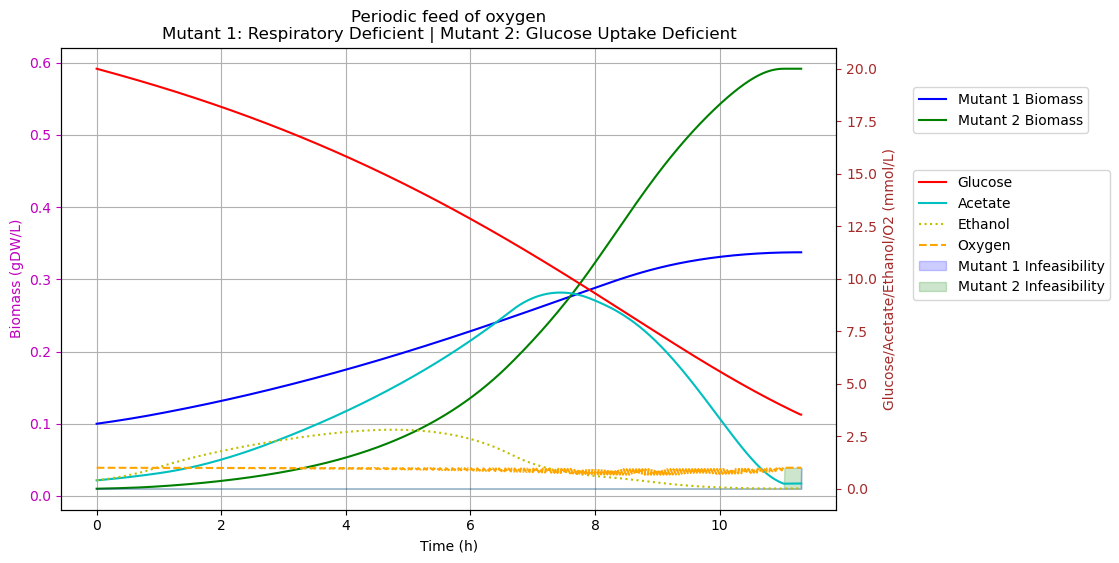

In [87]:
# t = np.linspace(0, niter * 0.01, niter + 1)
n_t = len(t_global)
t = t_global

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(t, mass_global[0][:n_t], label='Mutant 1 Biomass', color='b')
ax.plot(t, mass_global[1][:n_t], label='Mutant 2 Biomass', color='g')
ax.tick_params(axis='y', colors='m')
ax2 = plt.twinx(ax)
ax2.plot(t, glucose_global[:n_t], color='r', label='Glucose')
ax2.plot(t, acetate_global[:n_t], color='c', label='Acetate', linestyle='-')
ax2.plot(t, etoh_global[:n_t], color='y', label='Ethanol', linestyle=':')
ax2.plot(t, o2_global[:n_t], color='orange', label='Oxygen', linestyle='--')
ax2.tick_params(axis='y', colors='brown')

# plot on secondary y-axis the status of both models as colored bars going from 0 to the value of the status

ax2.fill_between(t, 0, sol_status_global[0][:n_t], color='b', alpha=0.2, label='Mutant 1 Infeasibility')
ax2.fill_between(t, 0, sol_status_global[1][:n_t], color='g', alpha=0.2, label='Mutant 2 Infeasibility')

ax.set_ylabel('Biomass (gDW/L)', color='m')
ax.set_xlabel('Time (h)', color='k')
ax2.set_ylabel('Glucose/Acetate/Ethanol/O2 (mmol/L)', color='brown')

ax.grid()

# Add a title in two lines. In the second line specifiy mutant 1 is respiratory deficient, and mutant 2 cannot uptake glucose
ax.title.set_text('Periodic feed of oxygen\nMutant 1: Respiratory Deficient | Mutant 2: Glucose Uptake Deficient')

# Place legends outside the figure frame on the top right
ax.legend(bbox_to_anchor=(1.09, 0.93), loc='upper left')
ax2.legend(bbox_to_anchor=(1.09, 0.75), loc='upper left')

plt.show()

### Simulating a chemostat with periodic feed of glucose and oxygen

In [ ]:
import copy

# Here we will use an initial concentration of glucose higher than the transport upper bound

# Prepare the initial conditions for the two models.
niter = 1500

mass_global = np.zeros((2,niter+1))
glucose_global = np.zeros(niter+1)
acetate_global = np.zeros(niter+1)
etoh_global = np.zeros(niter+1)
o2_global = np.zeros(niter+1)

sol1_global = np.zeros((5,niter+1))
sol2_global = np.zeros((5,niter+1))
sol_status_global = np.zeros((2,niter+1))

# Initial conditions
y0_1_mass = 0.1
y0_2_mass = 0.01
y0_glucose = 20
y0_acetate = 0.4 # minimal external concentration to support growth
y0_etoh = 0.4 # minimal external concentration to support growth
# y0_o2 = 0.35 # initial oxygen concentration
y0_o2 = 1.0 # initial oxygen concentration

y0_1 = [y0_1_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2
y0_2 = [y0_2_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2] # Initial conditions for biomass, glucose, acetate, etoh and o2  

# Initialize global solutions with initial conditions
sol1_global[:, 0] = y0_1  # Initial conditions for biomass, glucose and acetate in model1
sol2_global[:, 0] = y0_2  # Initial conditions for biomass, glucose and acetate in model2
sol_status_global[:, 0] = [0, 0]  # Initial status: 0 means successful integration, 1 means event triggered

# Initialize global concentrations with initial conditions for each concentration calculated explicitly
mass_global[:, 0] = [y0_1_mass, y0_2_mass]
glucose_global[0] = y0_glucose
acetate_global[0] = y0_acetate
etoh_global[0] = y0_etoh
o2_global[0] = y0_o2

# Initialize tensorboard logs for time 0
with tbwriter as writer:
    writer.add_scalar('mass_model_1', y0_1_mass, 0)
    writer.add_scalar('mass_model_2', y0_2_mass, 0)
    writer.add_scalar('glucose', y0_glucose, 0)
    writer.add_scalar('acetate', y0_acetate, 0)
    writer.add_scalar('etoh', y0_etoh, 0)
    writer.add_scalar('o2', y0_o2, 0)


t_global = [0]
delta_t = 0.01

for iter in tqdm(range(niter)):
    # print(iter)

    # Every 5 iteration bring back glucose and O2 concentration to original value
    if iter % 5 == 0:
        y0_glucose = 20
        y0_1[1] = y0_glucose
        y0_2[1] = y0_glucose
        y0_o2 = 1.0
        y0_1[4] = y0_o2
        y0_2[4] = y0_o2

    ts = np.linspace(0, delta_t, 2)  # Desired integration resolution and interval

    # if iter>0 and sol_status_global[0, iter-1] == 1:
    #     pass
    # else:

    with model1 as model:

        sol1 = solve_ivp(
            fun=dynamic_system_1,
            events=[infeasible_event_1],
            t_span=(ts.min(), ts.max()),
            y0=y0_1,
            t_eval=ts,
            rtol=1e-6,
            atol=1e-8,
            method='RK45'
        )

    # if iter>0 and sol_status_global[1, iter-1] == 1:
    #     pass
    # else:

    with model2 as model:

        sol2 = solve_ivp(
            fun=dynamic_system_2,
            events=[infeasible_event_2],
            t_span=(ts.min(), ts.max()),
            y0=y0_2,
            t_eval=ts,
            rtol=1e-6,
            atol=1e-8,
            method='RK45'
        )


    # Store the time points
    t_global.append(t_global[-1] + delta_t)            

    # Store the individual solutions in the global solutions
    sol1_global[:, iter+1] = sol1['y'][:, -1]
    sol2_global[:, iter+1] = sol2['y'][:, -1]
    sol_status_global[:, iter+1] = sol1['status'], sol2['status']

    # Update the masses
    y0_1_mass = sol1['y'][0, -1]
    y0_2_mass = sol2['y'][0, -1]

    # Update the glucose and acetate concentrations subtracting the initial value
    # from the sum of both strains updates for production or consumption
    d1_glucose = sol1['y'][1,0]-sol1['y'][1,-1]
    d2_glucose = sol2['y'][1,0]-sol2['y'][1,-1] 
    y0_glucose = y0_glucose - d1_glucose - d2_glucose

    d1_acetate = sol1['y'][2,0]-sol1['y'][2,-1]
    d2_acetate = sol2['y'][2,0]-sol2['y'][2,-1]
    y0_acetate = y0_acetate - d1_acetate - d2_acetate

    d1_etoh = sol1['y'][3,0]-sol1['y'][3,-1]
    d2_etoh = sol2['y'][3,0]-sol2['y'][3,-1]
    y0_etoh = y0_etoh - d1_etoh - d2_etoh

    d1_o2 = sol1['y'][4,0]-sol1['y'][4,-1]
    d2_o2 = sol2['y'][4,0]-sol2['y'][4,-1]
    y0_o2 = y0_o2 - d1_o2 - d2_o2

    # Update the initial conditions for both strains
    y0_1 = [y0_1_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2]
    y0_2 = [y0_2_mass, y0_glucose, y0_acetate, y0_etoh, y0_o2]

    # Store the results in the global solutions
    mass_global[:, iter+1] = [y0_1_mass, y0_2_mass]
    glucose_global[iter+1] = y0_glucose
    acetate_global[iter+1] = y0_acetate
    etoh_global[iter+1] = y0_etoh
    o2_global[iter+1] = y0_o2

    # Save logs for tensorboard
    # with writer as tbwriter:
    tbwriter.add_scalar('mass_model_1', y0_1_mass, iter+1)
    tbwriter.add_scalar('mass_model_2', y0_2_mass, iter+1)
    tbwriter.add_scalar('glucose', y0_glucose, iter+1)
    tbwriter.add_scalar('acetate', y0_acetate, iter+1)
    tbwriter.add_scalar('etoh', y0_etoh, iter+1)
    tbwriter.add_scalar('o2', y0_o2, iter+1)

    if sol1['status'] == 1 and sol2['status'] == 1:
        print(f"Both solutions are infeasible")
        break

    # Break tolerance on masses in the last 5 time points
    # n_t = len(t_global)
    # if n_t > 5 and np.max(np.abs(np.diff(mass_global[:, n_t-5:n_t], axis=1))) < 1e-3:
    #     print(f"Mass balance converged")
    #     break


  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [03:00<00:00,  8.29it/s]


#### Plot timelines of biomass, glucose, acetate, etoh and o2

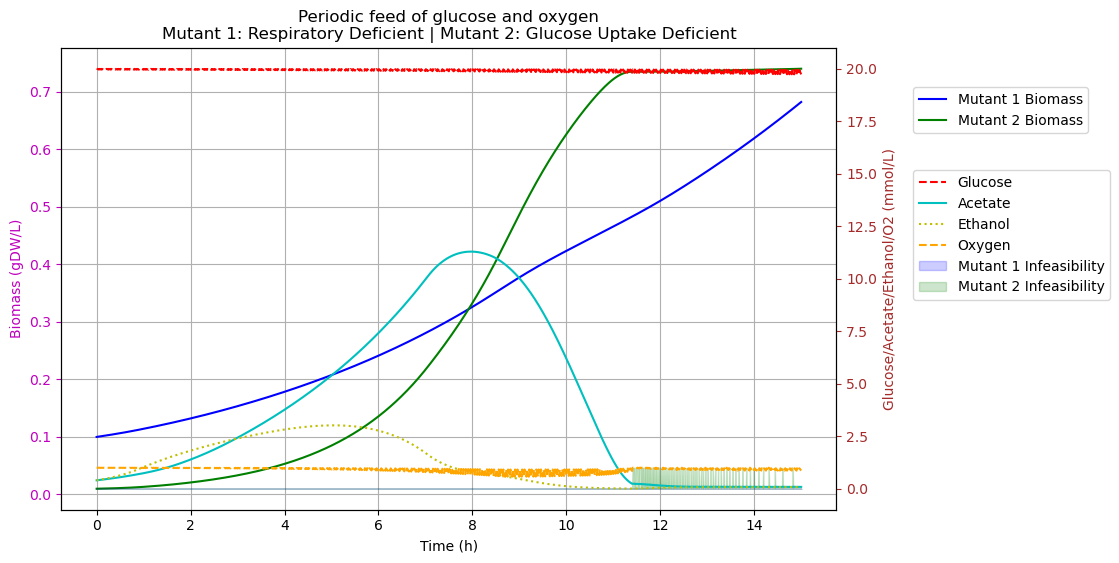

In [85]:
n_t = len(t_global)
t = t_global

fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(t, mass_global[0][:n_t], label='Mutant 1 Biomass', color='b')
ax.plot(t, mass_global[1][:n_t], label='Mutant 2 Biomass', color='g')
ax.tick_params(axis='y', colors='m')
ax2 = plt.twinx(ax)
ax2.plot(t, glucose_global[:n_t], color='r', label='Glucose', linestyle='--')
ax2.plot(t, acetate_global[:n_t], color='c', label='Acetate', linestyle='-')
ax2.plot(t, etoh_global[:n_t], color='y', label='Ethanol', linestyle=':')
ax2.plot(t, o2_global[:n_t], color='orange', label='Oxygen', linestyle='--')
ax2.tick_params(axis='y', colors='brown')

# plot on secondary y-axis the status of both models as colored bars going from 0 to the value of the status

ax2.fill_between(t, 0, sol_status_global[0][:n_t], color='b', alpha=0.2, label='Mutant 1 Infeasibility')
ax2.fill_between(t, 0, sol_status_global[1][:n_t], color='g', alpha=0.2, label='Mutant 2 Infeasibility')

ax.set_ylabel('Biomass (gDW/L)', color='m')
ax.set_xlabel('Time (h)', color='k')
ax2.set_ylabel('Glucose/Acetate/Ethanol/O2 (mmol/L)', color='brown')

ax.grid()

# Add a title in two lines. In the second line specifiy mutant 1 is respiratory deficient, and mutant 2 cannot uptake glucose
ax.title.set_text('Periodic feed of glucose and oxygen\nMutant 1: Respiratory Deficient | Mutant 2: Glucose Uptake Deficient')

# Place legends outside the figure frame on the top right
ax.legend(bbox_to_anchor=(1.09, 0.93), loc='upper left')
ax2.legend(bbox_to_anchor=(1.09, 0.75), loc='upper left')

plt.show()